In [1]:
UNET = 1

In [2]:
import os
import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')

if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH


In [3]:
from textwrap import wrap
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#TODO document jupyter
import pickle
import configparser
import sqlite3 as sl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'
datasetPathDatabaseAdditional =  configParser.get('COMMON', 'datasetPathDatabase') + '/datasetAdditional.db'
datasetPathDatabaseVgg =  configParser.get('COMMON', 'datasetPathDatabase') + '/datasetFacesBlurred.db'
image_size =  int(configParser.get('COMMON', 'resizeImageTo'))
begin_with_image_size = int(configParser.get('COMMON', 'begin_with_image_size'))
unet1_dim =  int(configParser.get('COMMON', 'unet1_dim'))
unet2_dim =  int(configParser.get('COMMON', 'unet2_dim'))
unet1_image_size =  int(configParser.get('COMMON', 'unet1_image_size'))
audio_embs =  str(configParser.get('COMMON', 'audio_embs'))
audio_length_used =  configParser.get('train_imagen', 'audio_length_used') 
model_filename =  configParser.get('train_imagen', 'model_filename')
sub_epochs=  int(configParser.get('train_imagen', 'sub_epochs') )
inner_epochs=  int(configParser.get('train_imagen', 'inner_epochs') )
batch_size=  int(configParser.get('train_imagen', 'batch_size') )
timesteps= int(configParser.get('COMMON', 'timesteps') )
sample_every=  int(configParser.get('train_imagen', 'sample_every') ) - 1
sample_probability = int(configParser.get('train_imagen', 'sample_probability') )
save_model_every=  int(configParser.get('train_imagen', 'save_model_every') ) - 1
sample_every_offset=  int(configParser.get('train_imagen', 'sample_every_offset') ) - 1
save_every_offset=  int(configParser.get('train_imagen', 'save_every_offset') ) - 1
imagen_samples_folder = configParser.get('train_imagen', 'imagen_samples_folder') 
db_chunk = int(configParser.get('train_imagen', 'db_chunk'))
dask_chunk = int(configParser.get('train_imagen', 'dask_chunk'))
stop_at_no_of_samples = int(configParser.get('train_imagen', 'stop_at_no_of_samples'))
epochs = int(configParser.get('train_imagen', 'epochs'))
ignore_speaker_embedding = bool(int(configParser.get('train_imagen', 'ignore_speaker_embedding') ))
ignore_speech_brain = bool(int(configParser.get('train_imagen', 'ignore_speech_brain') ))
ignore_pyannote_titanet_speakernet = bool(int(configParser.get('train_imagen', 'ignore_pyannote_titanet_speakernet') ))
ignore_audio_features = bool(int(configParser.get('train_imagen', 'ignore_audio_features') ))
ignore_pyAudioAnalysis = bool(int(configParser.get('train_imagen', 'ignore_pyAudioAnalysis') ))
ignore_librosa = bool(int(configParser.get('train_imagen', 'ignore_librosa') ))
ignore_image_guide = bool(int(configParser.get('train_imagen', 'ignore_image_guide') ))
ignore_additional_attributes = bool(int(configParser.get('train_imagen', 'ignore_additional_attributes') ))
ignore_age = bool(int(configParser.get('train_imagen', 'ignore_age') ))
ignore_gender = bool(int(configParser.get('train_imagen', 'ignore_gender') ))
ignore_ethnicity = bool(int(configParser.get('train_imagen', 'ignore_ethnicity') ))
ignore_language_spoken = bool(int(configParser.get('train_imagen', 'ignore_language_spoken') ))


pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None



In [4]:
def speaker_emb_preprocess(speaker_emb2):

    if(ignore_speaker_embedding or ignore_speech_brain):
        #print('ignore speech brain')
        return np.zeros((1,768))
    else:
        speaker_emb2 = pickle.loads(speaker_emb2)
        #print(speaker_emb2.print)
        speaker_emb2 = speaker_emb2.squeeze()
        speaker_emb2 = np.pad(speaker_emb2, (288), 'constant', constant_values=(0))
        speaker_emb2 = np.tile(speaker_emb2, (1, 1))
        speaker_emb2 = speaker_emb2 / 200.0
        #print(speaker_emb2.shape)
        #speaker_emb2 = np.array(speaker_emb2).tolist()
        #print(type(speaker_emb2))
        return speaker_emb2


def audio_emb_preprocess2(speaker_emb2):
    
    if(ignore_pyannote_titanet_speakernet or ignore_speaker_embedding):
        #print('ignore speech brain')
        return np.zeros((28,768))
    else:
        #print(speaker_emb2)
        speaker_emb2 = pickle.loads(speaker_emb2)
        a = speaker_emb2 #np.zeros(shape=(24, 512))
        a = a[-28:,:] # Actually only last 39 are the relevant ones
        #print('au')
        #print(a.shape)
        b = np.zeros(shape=(a.shape[0], 768-a.shape[1]))
        #c = np.zeros(shape=(28-a.shape[0], 768))
        arr = np.concatenate((a, b), axis=1)
        #arr = np.concatenate((arr, c), axis=0)
        arr = arr / (1 if(audio_embs == 'wav2vec') else 10 if(audio_embs == 'openl3')  else 1 if(audio_embs == 'pyannoteTitaNet') else 1)
        #print(str(arr.max()))
        #print(arr.shape)
        speaker_emb2 = np.array(arr)
        return speaker_emb2

def audio_features_preprocess(video_id):
    #  79 belong to pyaudioanalysis
    # 111 belogn to liborsa
    if(ignore_audio_features):
        #print('ignore speech brain')
        return np.zeros((190,768))
    else:
        #print(video_id)
        conAdditional = sl.connect(datasetPathDatabaseAdditional)
        cur = conAdditional.cursor()
        sql = '''SELECT AUDIO_FEATURES FROM AUDIO WHERE VIDEO_ID = ?'''
        cur.execute(sql, [video_id])
        audio_features = cur.fetchall()
        #print(audio_features[0])
        audio_features = pickle.loads(audio_features[0][0])
        #print(audio_features.shape) # 190 x 128
        audio_features = audio_features[0:190]
        
        #import sys
        #np.set_printoptions(threshold=sys.maxsize)
        #print(np.argwhere(audio_features == 0))

        if(ignore_pyAudioAnalysis and not ignore_librosa):
            zpa = np.zeros((190-110,128))
            audio_features = audio_features[80:190]
            audio_features = np.vstack((audio_features,zpa))
            #print('ignore pyAudioAnalysis')
            #print(audio_features.shape)
        elif(ignore_librosa and not ignore_pyAudioAnalysis):
            zpa = np.zeros((190-80,128))
            audio_features = audio_features[0:80]
            audio_features = np.vstack((audio_features,zpa))
            #print('ignore librosa')
            #print(audio_features.shape)
        else:
            audio_features = np.zeros((190,128))
            #print('ignore pyaudioanalysis and librosa')


        z1 = np.zeros((190,768-128))
        audio_features = np.hstack((audio_features,z1))
        audio_features = audio_features / 100.0
        #print(audio_features.shape)
    return audio_features

def audio_transformer_features_preprocess(video_id):
    #print(video_id)
    conAdditional = sl.connect(datasetPathDatabaseAdditional)
    cur = conAdditional.cursor()
    sql = '''SELECT AUDIO_FEATURES FROM AUDIO_TRANSFORMER WHERE VIDEO_ID = ?'''
    cur.execute(sql, [video_id])
    audio_features = cur.fetchall()
    #print(audio_features[0])
    audio_features = pickle.loads(audio_features[0][0])
    #print(audio_features.shape) # 514 x 768
    audio_features = audio_features.squeeze()
    audio_features = audio_features[0::3]#172*768
    #z1 = np.zeros((161,768-128))
    #audio_features = np.hstack((audio_features,z1))
    #audio_features = audio_features / 100.0
    return audio_features

import random
def image_guide_preprocess(face_id):
    #print(face_id)

    if(random.random() > 2):
        image_guide = np.zeros((49,768))
        #print(image_guide.shape)
    else:
        conAdditional = sl.connect(datasetPathDatabaseVgg)
        cur = conAdditional.cursor()
        sql = '''SELECT BLURRED_FACE_EMB FROM FACES_BLURRED WHERE FACE_ID = ?'''
        cur.execute(sql, [face_id])
        image_guide = cur.fetchall()
        #print(image_guide)
        image_guide = pickle.loads(image_guide[0][0])
        image_guide = image_guide.squeeze() #197 x 768
        image_guide = image_guide[1::4] #49 x 768
    return image_guide


#boxBlurMin =  int(configParser.get('extractVggBlurred', 'boxBlurMin'))
#boxBlurMax =  int(configParser.get('extractVggBlurred', 'boxBlurMax'))

#gaussianBlurMin =  int(configParser.get('extractVggBlurred', 'gaussianBlurMin'))
#gaussianBlurMax =  int(configParser.get('extractVggBlurred', 'gaussianBlurMax'))


from PIL import Image,ImageFilter
import random
#import cv2
import numpy as np
#from matplotlib import pyplot as plt
  


def image_guide_preprocess_low_res_dummy(path):
    #print(face_id)

    image_guide = np.zeros((1, 768))
    return image_guide

def image_guide_preprocess_low_res(path):
    #print(face_id)


    if(ignore_image_guide):
        return np.nan
    else:

        image = Image.open(path).convert('RGB')

        #print(image.size)

        w_s = image_size / (1+2 * 0.4)
        h_s = image_size / (1+2 * 0.4)

        image = image.crop((0.2*w_s, 0.0*h_s, 1.6*w_s, 1.4*h_s))

        image = image.resize((image_size,image_size))

        image = image.resize((begin_with_image_size,begin_with_image_size))
        im = image
        

        #print('saving')
        #image.save('opop.png')

        #print(np.array(image,np.float32).shape)

        pix = np.array(image, np.float32)
        pix = np.moveaxis(pix, -1, 0)

        pix = pix / 255
        image.close()
        im.close()
        return pix
    return image_guide




In [5]:



def process_age(age):
    if(random.random() < 0.2 or ignore_age or ignore_additional_attributes):
        x = np.zeros(768)
        x[767] = 1
        return x
    else:
        try:
            x = np.ones(768) * (age / 100.0)
            x[767] = 0
        except:
            x = np.zeros(768)
            x[767] = 1

        return x

def process_gender(gender):
    if(random.random() < 0.2 or ignore_gender or ignore_additional_attributes):
        return np.zeros(768)
    elif(gender == 'man'):
        return np.ones(768)
    elif(gender == "woman"):
        return np.ones(768) * -1
    else:
        return np.zeros(768)
    
# TODO
def process_ethnicity(eth):
    x = np.zeros(768)
    if(random.random() < 0.2 or ignore_ethnicity or ignore_additional_attributes):
        x = x
    elif(eth == "indian"):
        x[0] = 1
    elif(eth == "asian"):
        x[16]=1
    elif(eth == "latino hispanic"):
        x[2]=1
    elif(eth == "black"):
        x[3]=1
    elif(eth == "middle eastern"):
        x[4]=1
    elif(eth == "white"):
        x[5]=1 
    else:
        x = x
    return x     

def process_language(lan):
    x = np.zeros(768)
    if(random.random() < 0.2 or ignore_language_spoken or ignore_additional_attributes):
        x = x
    elif(lan == "Arabic"):
        x[0] = 1
    elif(lan == "Portuguese"):
        x[16]=1
    elif(lan == "Romansh_Sursilvan"):
        x[2]=1
    elif(lan == "Japanese"):
        x[3]=1
    elif(lan == "Ukranian"):
        x[4]=1
    elif(lan == "German"):
        x[5]=1   
    elif(lan == "Chinese_China"):
        x[6]=1   
    elif(lan == "Welsh"):
        x[7]=1  
    elif(lan == "English"):
        x[8]=1
    elif(lan == "Kabyle"):
        x[9]=1 
    elif(lan == "Kyrgyz"):
        x[10]=1
    elif(lan == "Georgian"):
        x[11]=1
    elif(lan == "Persian"):
        x[12]=1 
    elif(lan == "French"):
        x[13]=1
    elif(lan == "Interlingua"):
        x[14]=1
    elif(lan == "Swedish"):
        x[15]=1
    elif(lan == "Spanish"):
        x[16]=1 
    elif(lan == "Dhivehi"):
        x[17]=1
    elif(lan == "Kinyarwanda"):
        x[18]=1 
    elif(lan == "Tatar"):
        x[19]=1
    elif(lan == "Hakha_Chin"):
        x[20]=1 
    elif(lan == "Tamil"):
        x[21]=1 
    elif(lan == "Greek"):
        x[22]=1
    elif(lan == "Latvian"):
        x[23]=1 
    elif(lan == "Russian"):
        x[24]=1
    elif(lan == "Breton"):
        x[25]=1
    elif(lan == "Catalan"):
        x[26]=1    
    elif(lan == "Maltese"):
        x[27]=1 
    elif(lan == "Slovenian"):
        x[28]=1    
    elif(lan == "Indonesian"):
        x[29]=1    
    elif(lan == "Dutch"):
        x[30]=1
    elif(lan == "Chinese_Taiwan"):
        x[31]=1 
    elif(lan == "Sakha"):
        x[32]=1 
    elif(lan == "Polish"):
        x[33]=1 
    elif(lan == "Czech"):
        x[34]=1 
    elif(lan == "Romanian"):
        x[35]=1 
    elif(lan == "Mangolian"):
        x[36]=1 
    elif(lan == "Italian"):
        x[37]=1 
    elif(lan == "Chinese_Hongkong"):
        x[38]=1 
    elif(lan == "Estonian"):
        x[39]=1 
    elif(lan == "Basque"):
        x[40]=1 
    elif(lan == "Esperanto"):
        x[41]=1 
    elif(lan == "Frisian"):
        x[42]=1 
    elif(lan == "Turkish"):
        x[43]=1 
    elif(lan == "Chuvash"):
        x[44]=1 
    else:
        x = x
    return x       

In [6]:

def process_input(row):
    #print(row)
    age = row["caption_a"]
    ethnicity=row["caption_e"]
    gender=row["caption_g"]
    language=row["caption_l"]
    speaker_emb=row["SPEAKER_EMB"]
    audio_emb=row["AUDIO_EMB"]
    audio_features=row["AUDIO_FEATURES"]
    image_guide=row["image_guide"]
    #print(image_guide)
    #print(speaker_emb)
    speaker_emb = np.asarray(speaker_emb, dtype=np.float32)
    speaker_emb = speaker_emb.squeeze()
    audio_emb = np.asarray(audio_emb, dtype=np.float32)
    audio_emb = audio_emb.squeeze()
    #print(speaker_emb.shape)
    h = np.vstack((age, ethnicity))
    h = np.vstack((h, gender))
    h = np.vstack((h, language))
    h = np.vstack((h, speaker_emb))
    h = np.vstack((h, audio_emb))
    h = np.vstack((h,audio_features))
    h = np.vstack((h,image_guide))
    #print('aaaaaaaaaaa')
    #print(h.shape)
    j = np.zeros(768)
    j = np.tile(j,(256-h.shape[0],1))
    h = np.vstack((h, j))
    #print(h.shape)
    
    return h





def process_image_path(path):
    
    image = Image.open(path).convert('RGB')

    w_s = image_size / (1+2 * 0.4)
    h_s = image_size / (1+2 * 0.4)

    #print(image.size)
    image = image.crop((0.2*w_s,0.0*h_s,1.6*w_s,1.4*h_s))
    image = image.resize((image_size,image_size))

    #print('saving')
    #image.save(str(random.random()) + '.png')

    

    #print(np.array(image,np.float32).shape)
    pix = np.array(image,np.float32)
    pix = np.moveaxis(pix, -1, 0)
    
    pix = pix / 255
    image.close()
    return pix

import multiprocessing
import train_imagen_batch
import dask.dataframe as dd
import math

procs = []

for epoch in range(epochs):
    print('-------------------- TRAINING IN EPOCH = ' + str(epoch) + ' ---------------------')
    stop_now = False


    while(not stop_now):

        con = sl.connect(datasetPathDatabase)

        print("Getting Data...")
        #import time
        #start_time = time.time()
        ## TODO: NEED TO CHECK F.ID CORRESPONDS TO CORRECT FACE_PATH

        data = con.execute("SELECT V.ID,F.ID,V.VIDEO_PATH, V.AGE CAPTION_A, " + 
                            "V.ETHNICITY CAPTION_E, " +
                            "lower(V.GENDER) CAPTION_G, " +
                                "A.SPEAKER_EMB, "+ ("A.WAV_TO_VEC, " if(audio_embs == 'wav2vec') else "A.AUDIO_EMB2, " if(audio_embs == 'openl3')  else "A.PYANNOTE_TITANET, " if(audio_embs == 'pyannoteTitaNet') else ', ') +
                            "A.AUDIO_FEATURES, " +
                            "A.LANG CAPTION_L, "+
                            "F.FACE_PATH "+
                            "FROM VIDEO V "+
                            "INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID " +
                            "INNER JOIN FACE F ON F.ID = (select ID from FACE f2 where f2.video_id = v.ID ORDER By ID limit 1 ) " + 
                            "WHERE AUDIO_LENGTH = " + audio_length_used + ' ' +
                            "AND V.ID in (select V2.ID from VIDEO v2 WHERE V2.TRAINED IS NULL AND AUDIO_PRE IN (3,4) AND FACES_PRE = 2 ORDER BY ABS(RANDOM()) LIMIT "+ str(db_chunk) + ")" )
        dataGotten = data.fetchall()

        
        print("Data Gotten")
        for ps in procs:
            ps.join()
        procs.clear()

        if(len(dataGotten) == 0):
            stop_now = True

        

        print("Preprocessing Data...")
        df = pd.DataFrame(dataGotten,columns = ['ID','FACE_ID','VIDEO_PATH','caption_a','caption_e','caption_g','SPEAKER_EMB','AUDIO_EMB','AUDIO_FEATURES','caption_l','image_path'])
        df = df.sample(frac=1).reset_index(drop=True)
        df = dd.from_pandas(df, npartitions=int(db_chunk/dask_chunk))
        df["image_guide"] = np.nan




        



        #print(df.head(10))
        data_frame = df[["ID","FACE_ID","image_path","caption_a","caption_e","caption_g","caption_l"]]
        data_frame['SPEAKER_EMB'] = df['SPEAKER_EMB']
        data_frame['AUDIO_EMB'] = df['AUDIO_EMB']
        data_frame['image_guide'] = df['image_guide']

        
        data_frame['SPEAKER_EMB'] = data_frame['SPEAKER_EMB'].apply(lambda x: speaker_emb_preprocess(x),meta=('1', 'object'))
        data_frame['AUDIO_EMB'] = data_frame['AUDIO_EMB'].apply(lambda x: audio_emb_preprocess2(x),meta=('1', 'object'))
        data_frame['AUDIO_FEATURES'] = data_frame['ID'].apply(lambda x: audio_features_preprocess(x),meta=('1', 'object'))
        data_frame = data_frame.drop(['ID'], axis=1)
        data_frame['image_guide'] = data_frame['image_path'].apply(lambda x: image_guide_preprocess_low_res_dummy(x),meta=('1', 'str'))
        data_frame = data_frame.drop(['FACE_ID'], axis=1)
        data_frame['caption_a'] = data_frame['caption_a'].apply(lambda x: process_age(x),meta=('1', 'object'))
        data_frame['caption_g'] = data_frame['caption_g'].apply(lambda x: process_gender(x),meta=('1', 'object'))
        data_frame['caption_l'] = data_frame['caption_l'].apply(lambda x: process_language(x),meta=('1', 'object'))
        data_frame['caption_e'] = data_frame['caption_e'].apply(lambda x: process_ethnicity(x),meta=('1', 'object'))
        data_frame['low_res_image'] = data_frame['image_path'].apply(lambda x: image_guide_preprocess_low_res(x),meta=('1', 'object'))

        data_frame['INPUT'] = data_frame['SPEAKER_EMB']
        #print(data_frame)

        data_frame['INPUT'] = data_frame.apply(process_input,args=(),axis=1,meta=('1', 'object'))

        #for index, row in data_frame.iterrows():
        #    x = process_input(data_frame.loc[index,"caption_a"],data_frame.loc[index,"caption_e"]
        #                        ,data_frame.loc[index,"caption_g"],
        #                    data_frame.loc[index,"caption_l"],data_frame.loc[index,"SPEAKER_EMB"],
        #                    data_frame.loc[index,"AUDIO_EMB"],data_frame.loc[index,"AUDIO_FEATURES"],
        #                    data_frame.loc[index,"image_guide"])
        #    x = [x]
        #    #AADFS = AADFS
        #    data_frame.loc[index,"INPUT"] = x

        data_frame = data_frame.drop(['caption_e', 'caption_g','caption_l','SPEAKER_EMB','AUDIO_EMB'], axis=1)


        data_frame['image_path'] = data_frame['image_path'].apply(lambda x: process_image_path(x),meta=('1', 'str'))
        data_frame.compute()

        #print("--- %s seconds ---" % (time.time() - start_time))
        #raise('aa')
        print("Data Preprocessed...")
        

        

        parts = range(data_frame.npartitions)

        for sub_epoch in range(sub_epochs):

            print('Training in sub epoch ' + str(sub_epoch) + ' from ' + str(sub_epochs))

            for part_no in parts:

                print('Training in part ' + str(part_no))

                part = data_frame[['INPUT','image_path','low_res_image']].partitions[part_no]

                

                input0 = np.array(part['INPUT'])
                input0 = np.array([np.array(xi) for xi in input0])
                input0[np.isnan(input0)] = 0
                input0[input0 > 10] = 10
                input0[input0 < -10] = -10
                #print(sys.getsizeof(input))
                
                output = np.array(part['image_path'])
                output = np.array([np.array(xi) for xi in output])
                output.squeeze().shape
                #print(sys.getsizeof(output))

                input2 = np.array(part['low_res_image'])
                input2 = np.array([np.array(xi) for xi in input2])
                input2.squeeze()
                #print(sys.getsizeof(input2))
                


            
                
                #print(len(procs))
                #if(len(procs) > 0):
                #    procs[0].join() # Wait for previous process to finish
                #    print("Model trained using a batch of data...")
                #    procs = []
                #print(len(procs))


                print("Training model ...")
                
                if(np.shape(input0)[0] > 0):

                    if(UNET == 1):
                        proc = multiprocessing.Process(target=train_imagen_batch.train_batch_unet1, args=(input0,input2,output,model_filename,inner_epochs,batch_size,sample_every,save_model_every,image_size,unet1_dim,unet2_dim,timesteps,begin_with_image_size,unet1_image_size,imagen_samples_folder,sample_probability,dask_chunk,ignore_image_guide,))
                    else:
                        proc = multiprocessing.Process(target=train_imagen_batch.train_batch_unet2, args=(input0,input2,output,model_filename,inner_epochs,batch_size,sample_every,save_model_every,image_size,unet1_dim,unet2_dim,timesteps,begin_with_image_size,unet1_image_size,imagen_samples_folder,sample_probability,dask_chunk,ignore_image_guide,))
                    procs.append(proc)
                    proc.start()


                    if(sub_epochs != 1):
                        for ps in procs:
                            ps.join()
                        procs.clear()


                

                    #print("Model trained using this batch of data...")

                    #proc = multiprocessing.Process(target=train_imagen_batch.train_batch_unet2, args=(input,output,model_filename,sub_epochs,batch_size,sample_every,save_model_every,image_size,unet1_dim,unet2_dim,))
                    #proc.start()two_unets_pyannote_nemo
                    #proc.join()





                
                    data.close()

                    data5 = np.array(df['ID']).astype('int')
                    data6 = []
                    for x in data5:
                        data6.append(int(x))
                    print(len(data6))
                    #print(data6)
                    sql5 = "UPDATE VIDEO SET TRAINED = 1 WHERE ID IN ({0})".format(', '.join('?' for _ in data6))
                    #print(sql5)
                    cur5 = con.cursor()
                    cur5.execute(sql5, data6)
                    con.commit()
                    cur5.close()
                else:
                    stop_now == True


        data10 = con.execute("SELECT COUNT(*) FROM VIDEO v WHERE V.TRAINED = 1")
        dataGotten10 = data10.fetchall()


        print('-------------')




        #print(dataGotten10[0])
        if(dataGotten10[0][0] > stop_at_no_of_samples or stop_now == True):
            for ps in procs:
                ps.join()
            procs.clear()
            print('--------------- FINISHED ------------------')
            stop_now = True
            sql50 = "UPDATE VIDEO SET TRAINED = NULL"
            cur50 = con.cursor()
            cur50.execute(sql50)
            con.commit()
            cur50.close()
            print('--------------- TRAINED COLUMN RESET ------------------')
        


        con.close()
        del dataGotten
    
        del df
        del data_frame
        del input0
        del input2
        del output
        gc.collect()

In [7]:
from scipy.signal import savgol_filter
from torch.utils.data import TensorDataset, DataLoader
import time
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor,Compose
import dask.dataframe as dd
from multiprocessing import Manager,RLock,Value

class CustomDataset(Dataset):

    total_rows = None
    con = None
    lock = None
    samples_seen =  Value('i', 0)

    def no_of_samples_seen(self):
        return self.samples_seen.value

    def __init__(self,datasetPathDatabase_a,lock,last_sample_no):
        self.lock = lock
        self.samples_seen.value = last_sample_no
        self.con = sl.connect(datasetPathDatabase_a)
        pass



    def __len__(self):
        
        if(self.total_rows == None):
            self.lock.acquire(block=True)
            data = self.con.execute("SELECT COUNT(*) FROM VIDEO v ")
            count = data.fetchall()
            self.total_rows = count[0][0]
            data.close()
            print("Found " + str(self.total_rows) + " data points.")

            #data = self.con.execute("SELECT COUNT(*) FROM VIDEO v WHERE V.TRAINED = 1")
            #count = data.fetchall()
            #data.close()
            #self.samples_seen.value = count[0][0]
            #print("Starting from " + str(self.samples_seen.value) + " data points.")
            self.lock.release()

        return self.total_rows


    def __getitem__(self, idx):
        self.lock.acquire(block=True)
        #print("lock acquired on getitem p1")
        sql = ("SELECT V.ID,F.ID,V.VIDEO_PATH, V.AGE CAPTION_A, " + 
                            "V.ETHNICITY CAPTION_E, " +
                            "lower(V.GENDER) CAPTION_G, " +
                                "A.SPEAKER_EMB, "+ ("A.WAV_TO_VEC, " if(audio_embs == 'wav2vec') else "A.AUDIO_EMB2, " if(audio_embs == 'openl3')  else "A.PYANNOTE_TITANET, " if(audio_embs == 'pyannoteTitaNet') else ', ') +
                            "A.AUDIO_FEATURES, " +
                            "A.LANG CAPTION_L, "+
                            "F.FACE_PATH "+
                            "FROM VIDEO V "+
                            "INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID " +
                            "INNER JOIN FACE F ON F.ID = (select ID from FACE f2 where f2.video_id = v.ID ORDER By ID limit 1 ) " + 
                            "WHERE AUDIO_LENGTH = " + audio_length_used + ' ' +
                            "AND V.ID in (select V2.ID from VIDEO v2 WHERE V2.TRAINED IS NULL AND AUDIO_PRE IN (3,4) AND FACES_PRE = 2 ORDER BY ABS(RANDOM()) LIMIT 1"+ ")")
        data = self.con.execute(sql)
        dataGotten = data.fetchall()
        df = pd.DataFrame(dataGotten,columns = ['ID','FACE_ID','VIDEO_PATH','caption_a','caption_e','caption_g','SPEAKER_EMB','AUDIO_EMB','AUDIO_FEATURES','caption_l','image_path'])
        data.close()
        
        #print("aaaa" + str(len(df)))
        if(len(df) == 0):
            print("Trying to get items")
            data = self.con.execute(sql)
            dataGotten = data.fetchall()
            df = pd.DataFrame(dataGotten,columns = ['ID','FACE_ID','VIDEO_PATH','caption_a','caption_e','caption_g','SPEAKER_EMB','AUDIO_EMB','AUDIO_FEATURES','caption_l','image_path'])
            data.close()
            
            if(len(df) == 0):
                print("Trying to get items")
                data = self.con.execute(sql)
                dataGotten = data.fetchall()
                df = pd.DataFrame(dataGotten,columns = ['ID','FACE_ID','VIDEO_PATH','caption_a','caption_e','caption_g','SPEAKER_EMB','AUDIO_EMB','AUDIO_FEATURES','caption_l','image_path'])
                data.close()

                if(len(df) == 0):
                    print("Trying to get items")
                    data = self.con.execute(sql)
                    dataGotten = data.fetchall()
                    df = pd.DataFrame(dataGotten,columns = ['ID','FACE_ID','VIDEO_PATH','caption_a','caption_e','caption_g','SPEAKER_EMB','AUDIO_EMB','AUDIO_FEATURES','caption_l','image_path'])
                    data.close()

                    if(len(df) == 0):
                        print("Reintializing dataset")
                        sql50 = "UPDATE VIDEO SET TRAINED = NULL"
                        cur50 = self.con.cursor()
                        cur50.execute(sql50)
                        self.con.commit()
                        cur50.close()

                        data = self.con.execute(sql)
                        dataGotten = data.fetchall()
                        df = pd.DataFrame(dataGotten,columns = ['ID','FACE_ID','VIDEO_PATH','caption_a','caption_e','caption_g','SPEAKER_EMB','AUDIO_EMB','AUDIO_FEATURES','caption_l','image_path'])
                        data.close()
        #print("released first lock")
        self.lock.release()

        
        
        df = df.sample(frac=1).reset_index(drop=True)
        df = dd.from_pandas(df, npartitions=1)
        df["image_guide"] = np.nan

        #print(df.head(10))
        data_frame = df[["ID","FACE_ID","image_path","caption_a","caption_e","caption_g","caption_l"]]
        data_frame['SPEAKER_EMB'] = df['SPEAKER_EMB']
        data_frame['AUDIO_EMB'] = df['AUDIO_EMB']
        data_frame['image_guide'] = df['image_guide']

        
        data_frame['SPEAKER_EMB'] = data_frame['SPEAKER_EMB'].apply(lambda x: speaker_emb_preprocess(x),meta=('1', 'object'))
        data_frame['AUDIO_EMB'] = data_frame['AUDIO_EMB'].apply(lambda x: audio_emb_preprocess2(x),meta=('1', 'object'))
        data_frame['AUDIO_FEATURES'] = data_frame['ID'].apply(lambda x: audio_features_preprocess(x),meta=('1', 'object'))
        data_frame = data_frame.drop(['ID'], axis=1)
        data_frame['image_guide'] = data_frame['image_path'].apply(lambda x: image_guide_preprocess_low_res_dummy(x),meta=('1', 'str'))
        data_frame = data_frame.drop(['FACE_ID'], axis=1)
        data_frame['caption_a'] = data_frame['caption_a'].apply(lambda x: process_age(x),meta=('1', 'object'))
        data_frame['caption_g'] = data_frame['caption_g'].apply(lambda x: process_gender(x),meta=('1', 'object'))
        data_frame['caption_l'] = data_frame['caption_l'].apply(lambda x: process_language(x),meta=('1', 'object'))
        data_frame['caption_e'] = data_frame['caption_e'].apply(lambda x: process_ethnicity(x),meta=('1', 'object'))
        data_frame['low_res_image'] = data_frame['image_path'].apply(lambda x: image_guide_preprocess_low_res(x),meta=('1', 'object'))

        data_frame['INPUT'] = data_frame['SPEAKER_EMB']
        #print(data_frame)

        data_frame['INPUT'] = data_frame.apply(process_input,args=(),axis=1,meta=('1', 'object'))

        #for index, row in data_frame.iterrows():
        #    x = process_input(data_frame.loc[index,"caption_a"],data_frame.loc[index,"caption_e"]
        #                        ,data_frame.loc[index,"caption_g"],
        #                    data_frame.loc[index,"caption_l"],data_frame.loc[index,"SPEAKER_EMB"],
        #                    data_frame.loc[index,"AUDIO_EMB"],data_frame.loc[index,"AUDIO_FEATURES"],
        #                    data_frame.loc[index,"image_guide"])
        #    x = [x]
        #    #AADFS = AADFS
        #    data_frame.loc[index,"INPUT"] = x

        data_frame = data_frame.drop(['caption_e', 'caption_g','caption_l','SPEAKER_EMB','AUDIO_EMB'], axis=1)


        data_frame['image_path'] = data_frame['image_path'].apply(lambda x: process_image_path(x),meta=('1', 'str'))
        data_frame.compute()

        part = data_frame[['INPUT','image_path','low_res_image']].partitions[0]

                

        input0 = np.array(part['INPUT'])
        input0 = np.array([np.array(xi) for xi in input0])
        input0[np.isnan(input0)] = 0
        input0[input0 > 10] = 10
        input0[input0 < -10] = -10
        #print(sys.getsizeof(input))
        
        output = np.array(part['image_path'])
        output = np.array([np.array(xi) for xi in output])
        output.squeeze().shape
        #print(sys.getsizeof(output))

        input2 = np.array(part['low_res_image'])
        input2 = np.array([np.array(xi) for xi in input2])
        input2.squeeze()
        #print(sys.getsizeof(input2))
        


    
        
        #print(len(procs))
        #if(len(procs) > 0):
        #    procs[0].join() # Wait for previous process to finish
        #    print("Model trained using a batch of data...")
        #    prProcess,
        input0 = torch.from_numpy(input0)
        input0 = input0.to(torch.float)


        input2 = torch.from_numpy(input2)
        input2 = input2.to(torch.float)

        output = torch.from_numpy(output)
        output = output.to(torch.float)

        input0 = input0.squeeze()
        input2 = input2.squeeze()
        output = output.squeeze()

        
        self.lock.acquire(block=True)
        #print("lock aquired on getitem p2")
        data5 = np.array(df['ID']).astype('int')
        data6 = []
        for x in data5:
            data6.append(int(x))
        #print(len(data6))
        #print(data6)
        sql5 = "UPDATE VIDEO SET TRAINED = 1 WHERE ID IN ({0})".format(', '.join('?' for _ in data6))
        #print(sql5)
        cur5 = self.con.cursor()
        cur5.execute(sql5, data6)
        self.con.commit()
        cur5.close()
        self.samples_seen.value +=  1
        print (self.samples_seen.value,end='\r')
        self.lock.release()
        #print("lock released on get item p2")
        return output,input0



In [8]:
def plot_loss(sample_no,loss_value):

    if(UNET == 1):
        my_file = Path(model_filename + '/loss_total_1.picke')
        if my_file.is_file():
            with open(model_filename + '/loss_total_1.picke', 'rb') as handle:
                loss_total = pickle.load(handle)
        else:
            loss_total = []
    else:
        my_file = Path(model_filename + '/loss_total_2.picke')
        if my_file.is_file():
            with open(model_filename + '/loss_total_2.picke', 'rb') as handle:
                loss_total = pickle.load(handle)
        else:
            loss_total = []
    
    #print(loss_list)
    #print(loss_total)
    loss_total.append([sample_no,loss_value])

    if(UNET == 1):
        with open(model_filename +'/loss_total_1.picke', 'wb') as handle:
            pickle.dump(loss_total, handle)
    else:
        with open(model_filename +'/loss_total_2.picke', 'wb') as handle:
            pickle.dump(loss_total, handle)
    #print(loss_total)
    fig = plt.figure()
    x_val = [x[0] for x in loss_total]
    y_val = [x[1] for x in loss_total]
    plt.plot(x_val,y_val)
    plt.title("Training Loss")
    plt.xlabel("Training Sample")
    plt.ylabel("MSE Loss")
    



    if(UNET == 1):
        if(os.path.isfile(model_filename + '/loss_1_plot.png')):
            os.remove(model_filename + '/loss_1_plot.png')
        fig.savefig(model_filename + '/loss_1_plot.png')
    else:
        if(os.path.isfile(model_filename + '/loss_2_plot.png')):
            os.remove(model_filename + '/loss_2_plot.png')
        fig.savefig(model_filename + '/loss_2_plot.png')
    plt.close()

    try:
        fig = plt.figure()
        plt.plot(x_val[1000::],np.arange(len(y_val[1000::])) + 1000,y_val[1000::]
                ,'.',zorder=-100)

        #plt.axvline(x=1000,linestyle='--',color='green',label='1000 inner epochs')
        #plt.axvline(x=17000,linestyle='--',color='purple',label='100 inner epochs - 100000 unique samples seen' )
        #plt.axvline(x=23100,linestyle='-.',color='black',label='1 inner epoch - end of 1st epoch ')
        plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper right')
        plt.grid()
        yhat = savgol_filter(y_val, 1000, 3)
        plt.plot(x_val,np.arange(len(loss_total[1000::])) + 1000,yhat[1000::],'r')
        plt.title("Training Loss")
        plt.xlabel("Training Sample")
        plt.ylabel("MSE Loss")
        



        if(UNET == 1):
            if(os.path.isfile(model_filename + '/loss_zoomed_1_plot.png')):
                os.remove(model_filename + '/loss_zoomed_1_plot.png')
            fig.savefig(model_filename + '/loss_zoomed_1_plot.png')
        else:
            if(os.path.isfile(model_filename + '/loss_zoomed_2_plot.png')):
                os.remove(model_filename + '/loss_zoomed_2_plot.png')
            fig.savefig(model_filename + '/loss_zoomed_2_plot.png')
        plt.close()


        #fig = plt.figure()
        #smoothed = yhat[1000::]
        #smoothed = savgol_filter(smoothed, 500, 1)
        #price_series = pd.Series(smoothed)
        #price_series = price_series.pct_change().to_numpy()
        #plt.plot(np.arange(len(y_val[1000::])) + 1000,price_series,zorder=-100)
        #plt.axhline(linestyle='--',color='red')
        #plt.axvline(x=1000,linestyle='--',color='green',label='1000 inner epochs')
        #plt.axvline(x=17000,linestyle='--',color='purple',label='100 inner epochs - 100000 unique samples seen' )
        #plt.axvline(x=23100,linestyle='-.',color='black',label='1 inner epoch - end of 1st epoch ')
        #plt.legend(loc = 'lower center')
        #plt.grid()
        #plt.title("Smoothed Rate of Change of Training Loss")
        #plt.xlabel("Training Sample (~x" + str(int(dask_chunk)) + ")")
        #plt.ylabel("Rate of Change")
        #plt.show()

        #if(UNET == 1):
        #    if(os.path.isfile(model_filename + 'loss_roc_1_plot.png')):
        #        os.remove(model_filename + 'loss_roc_1_plot.png')
        #    fig.savefig(model_filename + 'loss_roc_1_plot.png')
        #else:
        #    if(os.path.isfile(model_filename + 'loss_roc_2_plot.png')):
        #        os.remove(model_filename + 'loss_roc_2_plot.png')
        #    fig.savefig(model_filename + 'loss_roc_2_plot.png')
        #plt.close()
    except:
        pass


    

In [9]:
last_sample_no = 0
my_file = Path(model_filename + '/last_sample_no.picke')
if my_file.is_file():
    with open(model_filename + '/last_sample_no.picke', 'rb') as handle:
        last_sample_no = pickle.load(handle)


In [10]:
my_dataset = CustomDataset(datasetPathDatabase,RLock(),last_sample_no)
print(len(my_dataset))

Found 1092009 data points.
1092009


In [11]:
my_dataloader = DataLoader(my_dataset,batch_size = batch_size * 16,shuffle=False,num_workers=16) # create your dataloader

no checkpoints found to load from at /media/gamal/Passport/checkpoint/noablation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


loss: 0.7698674872517586
epoch:1 from 100000


OSError: [Errno 22] Invalid argument: '/media/gamal/Passport/checkpoint/noablation\\last_sample_no.picke'

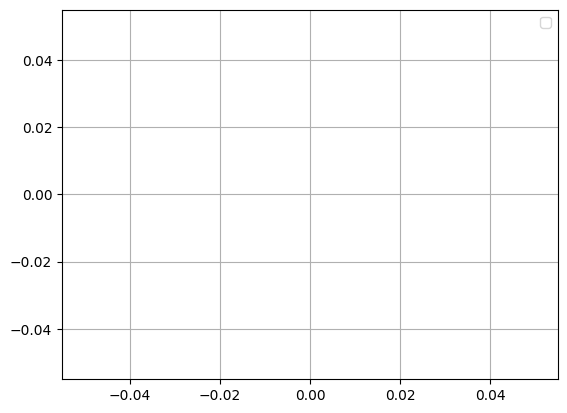

In [ ]:
from imagen_pytorch import Unet, Imagen, ImagenTrainer,NullUnet
from imagen_pytorch.data import Dataset

unet0 = NullUnet()  # add a placeholder "null" unet for the base unet

unet1 = Unet(
    dim = unet1_dim,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = unet2_dim,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

if(ignore_image_guide):
    unets = (unet1, unet2)
    image_sizes= (unet1_image_size, image_size)
    unet_to_train = UNET #1
    #start_image_or_video = None
else:
    unets = (unet0,unet1, unet2)
    image_sizes= (begin_with_image_size,unet1_image_size, image_size)
    unet_to_train = UNET + 1 #2
    #start_image_or_video = input2[:1,:]

#print(input2[:1,:])
#print(input2)

imagen = Imagen(
    unets = unets,
    image_sizes = image_sizes,
    timesteps = timesteps,
    cond_drop_prob = 0.1
).cuda()



trainer = ImagenTrainer(
    imagen = imagen,
    split_valid_from_train = False, # whether to split the validation dataset from the training
    checkpoint_every = 250,
    checkpoint_path = model_filename,
    max_checkpoints_keep = 2,
    only_train_unet_number = unet_to_train
).cuda()


trainer.add_train_dataloader(my_dataloader)

#if not os.path.exists(imagen_samples_folder):
#    os.makedirs(imagen_samples_folder)

#my_file = Path(model_filename)
#if my_file.is_file():
#    print('Using model file ' + model_filename)
#    trainer.load(model_filename)

#trainer.load_from_checkpoint_folder()

for i in range(epochs):
    
    loss = trainer.train_step(unet_number = unet_to_train,max_batch_size = batch_size)
    print(f'loss: {loss}')
    #print("At sample seen " + str(my_dataset.no_of_samples_seen()))
    plot_loss(my_dataset.no_of_samples_seen(),loss)
    #print(loss_list)
    #trainer.save_to_checkpoint_folder()
    print('epoch:' + str(i+1) + ' from ' + str(epochs))
    last_sample_no = my_dataset.no_of_samples_seen()
    with open(model_filename + '/last_sample_no.picke', 'wb') as handle:
        pickle.dump(last_sample_no, handle)
                